# Callin Switzer
# LSTM attempt with Moth Data

### One to many mapping

___

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it

In [2]:
import sys
sys.platform.startswith('linux')

True

In [3]:
os.environ.keys()

KeysView(environ({'XDG_SESSION_ID': '23', 'SHELL': '/bin/bash', 'TERM': 'xterm-color', 'SSH_CLIENT': '10.102.85.47 49837 22', 'SSH_TTY': '/dev/pts/8', 'USER': 'cswitzer', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:*.zip=01;31:*.z=01;31:*.Z=01;31:*.dz=01;31:*.gz=01;31:*.lrz=01;31:*.lz=01;31:*.lzo=01;31:*.xz=01;31:*.bz2=01;31:*.bz=01;31:*.tbz=01;31:*.tbz2=01;31:*.tz=01;31:*.deb=01;31:*.rpm=01;31:*.jar=01;31:*.war=01;31:*.ear=01;31:*.sar=01;31:*.rar=01;31:*.alz=01;31:*.ace=01;31:*.zoo=01;31:*.cpio=01;31:*.7z=01;31:*.rz=01;31:*.cab=01;31:*.jpg=01;35:*.jpeg=01;35:*.gif=01;35:*.bmp=01;35:*.pbm=01;35:*.pgm=01;35:*.ppm=01;35:*.tga=01;35:*.xbm=01;35:*.xpm=01;35:*.tif=01;35:*.tiff=01;35:*.png=01;35:*.svg=01;35:*

In [4]:
def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
        DropboxDirect = os.path.join("/media/cswitzer/HDD12TB/Dropbox")
    elif os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")

    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'mothMachineLearning_dataAndFigs', 'Data')
    figDir = os.path.join(DropboxDirect, 'mothMachineLearning_dataAndFigs', 'Figs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()
print(dataDir)

/media/cswitzer/HDD12TB/Dropbox/mothMachineLearning_dataAndFigs/Data


In [5]:
def readMyFile(filename, delimiter= ' '):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=delimiter, quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame((tmpdta)))

In [10]:
dataDir

'/media/cswitzer/HDD12TB/Dropbox/mothMachineLearning_dataAndFigs/Data'

In [11]:
os.path.isfile('/media/cswitzer/HDD12TB/Dropbox/mothMachineLearning_dataAndFigs/Data/Q_secondspray.csv')

False

In [12]:
os.path.isfile(os.path.join(dataDir, "Q_secondspray.csv"))

False

In [12]:
# read in data
spray2 = readMyFile(os.path.join(dataDir, "Q_secondspray.csv"), delimiter= ',')
forceAngle2 = readMyFile(os.path.join(dataDir, "ValSp3_secondspray.csv"), delimiter= ',')
print(spray2.shape)

spray1 = readMyFile(os.path.join(dataDir, "Q_firstspray.csv"), delimiter= ',')
forceAngle1 = readMyFile(os.path.join(dataDir, "ValSp3_firstspray.csv"), delimiter= ',')

spray = pd.concat((spray1, spray2), axis=1, ignore_index = True)
forceAngle = pd.concat((forceAngle1, forceAngle2), axis=1, ignore_index=True)
spray.shape

(100, 20000)


(100, 40000)

In [13]:
new_cols = ["x", "y", "theta", "phi", "x_dot", "y_dot", "theta_dot", "phi_dot"]

spray.rename(columns=dict(zip(spray.columns[[np.arange(8)]], new_cols)), inplace=True)

# add timestamp
spray['time'] = np.arange(0, 0.02, 2.0002e-04)
cols = spray.columns.tolist()
spray = spray[[cols[-1]] + cols[:-1]] 

In [14]:
spray.head()

,time,x,y,theta,phi,x_dot,y_dot,theta_dot,phi_dot,8,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,0.0000,0.000000,0.000000,0.78540,3.927,0.0001,0.00010,0.000000,0.000000,0.000000,...,0.18096,2.6958,0.34997,2.4985,0.78586,3.9530,35.052,249.73,0.18096,2.6958
1,0.0002,0.000103,0.000041,0.78541,3.927,1.0038,0.42265,0.048971,0.000594,-0.000117,...,2.42650,2.5106,0.35770,2.5485,0.78626,3.9536,40.747,246.03,2.45890,2.4867
2,0.0004,0.000405,0.000172,0.78542,3.927,1.9839,0.86875,0.057278,0.003732,-0.000463,...,2.40100,2.4679,0.36637,2.5980,0.78676,3.9540,45.105,243.67,2.42740,2.4223
3,0.0006,0.000906,0.000393,0.78543,3.927,2.9636,1.31530,0.064795,0.006861,-0.001037,...,2.34940,2.4276,0.37593,2.6470,0.78724,3.9545,49.448,241.32,2.36830,2.3605
4,0.0008,0.001603,0.000703,0.78544,3.927,3.9431,1.76200,0.072037,0.009950,-0.001839,...,2.28630,2.3888,0.38635,2.6955,0.78771,3.9550,53.786,238.99,2.29890,2.3002


In [15]:
fa = forceAngle.transpose()
fa.columns = np.concatenate((np.array([new_cols[jj] + "_" + str(99) for jj in range(len(new_cols))]).flatten(), ["F", "alpha", "tao", "cost"]))
print(fa.shape)
fa.head()

(5000, 12)


,x_99,y_99,theta_99,phi_99,x_dot_99,y_dot_99,theta_dot_99,phi_dot_99,F,alpha,tao,cost
0,0.96882,0.44350,0.79232,3.9286,96.742,44.518,0.57936,0.10528,6381.8,6.0842,13183.0,4.179500e+08
1,-1.14110,1.90170,0.82930,3.9425,-115.910,189.560,3.78200,0.97056,13312.0,1.2796,88270.0,7.807600e+07
2,-0.22157,0.47326,0.79274,3.9384,-22.268,47.327,0.66854,1.09090,3897.3,1.1061,-12274.0,3.973000e+08
3,-2.41960,6.00590,0.83930,3.9770,-248.120,598.450,4.32990,3.87880,36815.0,1.1494,28313.0,1.361700e+09
4,-1.96970,-0.33123,0.78896,3.9475,-196.920,-33.251,0.37852,2.05510,10861.0,2.4246,-48780.0,8.197200e+08


In [16]:
# make Fx and Fy
fa["Fx"] = fa.F * np.cos(fa.alpha)
fa["Fy"] = fa.F * np.sin(fa.alpha)


# numpy way
sparray = np.array(spray)

for ii in np.arange(1, spray.shape[1], step = 8):

    tmparr = sparray[0:, ii:ii+8].reshape(1, -1)

    if ii == 1:
        newArr = tmparr
    else: 
        newArr = np.vstack((newArr, tmparr))
        
newDF = pd.DataFrame(newArr)
print(newDF.shape)
newDF.head()

(5000, 800)


,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,0.000103,0.000041,...,0.57959,0.10563,0.96882,0.44350,0.79232,3.9286,96.742,44.518,0.57936,0.10528
1,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000117,0.000197,...,3.75040,0.97843,-1.14110,1.90170,0.82930,3.9425,-115.910,189.560,3.78200,0.97056
2,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000020,0.000046,...,0.66717,1.08110,-0.22157,0.47326,0.79274,3.9384,-22.268,47.327,0.66854,1.09090
3,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000249,0.000625,...,4.29750,3.87650,-2.41960,6.00590,0.83930,3.9770,-248.120,598.450,4.32990,3.87880
4,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000201,-0.000035,...,0.37533,2.03480,-1.96970,-0.33123,0.78896,3.9475,-196.920,-33.251,0.37852,2.05510


In [17]:
ColsLong = np.array([[new_cols[jj] + "_" + str(ii) for jj in range(len(new_cols))] for ii in range(100)]).flatten()

In [18]:
newDF.columns = ColsLong
print(newDF.shape)
newDF.head()

(5000, 800)


,x_0,y_0,theta_0,phi_0,x_dot_0,y_dot_0,theta_dot_0,phi_dot_0,x_1,y_1,...,theta_dot_98,phi_dot_98,x_99,y_99,theta_99,phi_99,x_dot_99,y_dot_99,theta_dot_99,phi_dot_99
0,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,0.000103,0.000041,...,0.57959,0.10563,0.96882,0.44350,0.79232,3.9286,96.742,44.518,0.57936,0.10528
1,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000117,0.000197,...,3.75040,0.97843,-1.14110,1.90170,0.82930,3.9425,-115.910,189.560,3.78200,0.97056
2,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000020,0.000046,...,0.66717,1.08110,-0.22157,0.47326,0.79274,3.9384,-22.268,47.327,0.66854,1.09090
3,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000249,0.000625,...,4.29750,3.87650,-2.41960,6.00590,0.83930,3.9770,-248.120,598.450,4.32990,3.87880
4,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000201,-0.000035,...,0.37533,2.03480,-1.96970,-0.33123,0.78896,3.9475,-196.920,-33.251,0.37852,2.05510


In [19]:
newDF.loc[newDF.x_99 == fa.x_99[0]]

,x_0,y_0,theta_0,phi_0,x_dot_0,y_dot_0,theta_dot_0,phi_dot_0,x_1,y_1,...,theta_dot_98,phi_dot_98,x_99,y_99,theta_99,phi_99,x_dot_99,y_dot_99,theta_dot_99,phi_dot_99
0,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,0.000103,0.000041,...,0.57959,0.10563,0.96882,0.4435,0.79232,3.9286,96.742,44.518,0.57936,0.10528


In [20]:
fa.head()

,x_99,y_99,theta_99,phi_99,x_dot_99,y_dot_99,theta_dot_99,phi_dot_99,F,alpha,tao,cost,Fx,Fy
0,0.96882,0.44350,0.79232,3.9286,96.742,44.518,0.57936,0.10528,6381.8,6.0842,13183.0,4.179500e+08,6255.872163,-1261.520797
1,-1.14110,1.90170,0.82930,3.9425,-115.910,189.560,3.78200,0.97056,13312.0,1.2796,88270.0,7.807600e+07,3821.853808,12751.579411
2,-0.22157,0.47326,0.79274,3.9384,-22.268,47.327,0.66854,1.09090,3897.3,1.1061,-12274.0,3.973000e+08,1746.580261,3484.021338
3,-2.41960,6.00590,0.83930,3.9770,-248.120,598.450,4.32990,3.87880,36815.0,1.1494,28313.0,1.361700e+09,15058.624471,33594.375334
4,-1.96970,-0.33123,0.78896,3.9475,-196.920,-33.251,0.37852,2.05510,10861.0,2.4246,-48780.0,8.197200e+08,-8186.862410,7136.988502


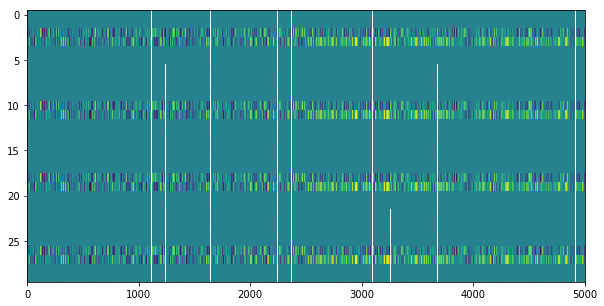

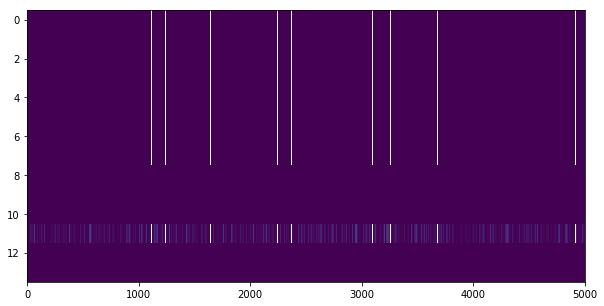

In [21]:
plt.figure(figsize = [10,5])

Y = np.array(fa)
X = np.array(newDF)

plt.imshow(np.transpose(X[:, 770:]), aspect="auto")

plt.figure(figsize = [10,5])
plt.imshow(np.transpose(Y), aspect="auto")

In [22]:
newDF.head()

,x_0,y_0,theta_0,phi_0,x_dot_0,y_dot_0,theta_dot_0,phi_dot_0,x_1,y_1,...,theta_dot_98,phi_dot_98,x_99,y_99,theta_99,phi_99,x_dot_99,y_dot_99,theta_dot_99,phi_dot_99
0,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,0.000103,0.000041,...,0.57959,0.10563,0.96882,0.44350,0.79232,3.9286,96.742,44.518,0.57936,0.10528
1,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000117,0.000197,...,3.75040,0.97843,-1.14110,1.90170,0.82930,3.9425,-115.910,189.560,3.78200,0.97056
2,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000020,0.000046,...,0.66717,1.08110,-0.22157,0.47326,0.79274,3.9384,-22.268,47.327,0.66854,1.09090
3,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000249,0.000625,...,4.29750,3.87650,-2.41960,6.00590,0.83930,3.9770,-248.120,598.450,4.32990,3.87880
4,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000201,-0.000035,...,0.37533,2.03480,-1.96970,-0.33123,0.78896,3.9475,-196.920,-33.251,0.37852,2.05510


In [23]:
# drop NA's
X = np.array(newDF.dropna())
Y = np.array(fa.dropna())

# check
print(all(X[:,99*8] == Y[:,0]))
print(len(X))

Y = Y[:, [10, 12, 13]]
Y.shape

True
4892


(4892, 3)

In [24]:
combDF = pd.merge(newDF.dropna(), fa.dropna(), left_on = np.array(newDF.columns[99*8:(99*8+8)]).tolist(), 
                  right_on = np.array(fa.columns[0:8]).tolist(), how = "inner")
print(combDF.shape)
combDF.head()

(4892, 806)


,x_0,y_0,theta_0,phi_0,x_dot_0,y_dot_0,theta_dot_0,phi_dot_0,x_1,y_1,...,x_dot_99,y_dot_99,theta_dot_99,phi_dot_99,F,alpha,tao,cost,Fx,Fy
0,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,0.000103,0.000041,...,96.742,44.518,0.57936,0.10528,6381.8,6.0842,13183.0,4.179500e+08,6255.872163,-1261.520797
1,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000117,0.000197,...,-115.910,189.560,3.78200,0.97056,13312.0,1.2796,88270.0,7.807600e+07,3821.853808,12751.579411
2,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000020,0.000046,...,-22.268,47.327,0.66854,1.09090,3897.3,1.1061,-12274.0,3.973000e+08,1746.580261,3484.021338
3,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000249,0.000625,...,-248.120,598.450,4.32990,3.87880,36815.0,1.1494,28313.0,1.361700e+09,15058.624471,33594.375334
4,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000201,-0.000035,...,-196.920,-33.251,0.37852,2.05510,10861.0,2.4246,-48780.0,8.197200e+08,-8186.862410,7136.988502


In [25]:
combDF.iloc[:, 800:803].head()

,F,alpha,tao
0,6381.8,6.0842,13183.0
1,13312.0,1.2796,88270.0
2,3897.3,1.1061,-12274.0
3,36815.0,1.1494,28313.0
4,10861.0,2.4246,-48780.0


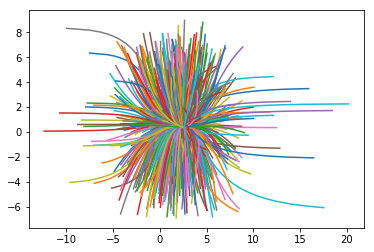

In [26]:

kk = 20000
for ii in range(1000):
    kk += 8
    tmp = np.array(spray.iloc[:, kk])
    t2 = np.array(spray.iloc[:, kk + 1])
    plt.plot(tmp, t2)
    #print(kk)

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import CuDNNLSTM
from keras.layers import Flatten


In [38]:
# create dataset
samples =  combDF.shape[0]
timesteps = np.arange(0, 0.02, 2.0002e-04).shape[0]
numTimesteps = 100
features = np.array(combDF.iloc[:,0:800])
features.shape

X = features
Y = combDF.iloc[:, 800:803]
print(Y.shape, X.shape, timesteps)

(4892, 3) (4892, 800) 100


In [29]:
np.array(Y.head())

array([[ 6.3818e+03,  6.0842e+00,  1.3183e+04],
       [ 1.3312e+04,  1.2796e+00,  8.8270e+04],
       [ 3.8973e+03,  1.1061e+00, -1.2274e+04],
       [ 3.6815e+04,  1.1494e+00,  2.8313e+04],
       [ 1.0861e+04,  2.4246e+00, -4.8780e+04]])

In [30]:
(X.shape[0], timesteps , -1)

(4892, 100, -1)

In [31]:
# reshape X --  [samples, time steps, features]
# reshape Y, so it's as long as X



#preallocate array
#YY = np.zeros((Y.shape[0], 99, 8))
X2 = X.reshape((X.shape[0], 100,  -1))
X2.shape


(4892, 100, 8)

In [32]:
X2[1, 1, :]


array([-1.1652e-04,  1.9705e-04,  7.8540e-01,  3.9270e+00, -1.1430e+00,
        1.9375e+00,  3.5151e-02,  2.9245e-02])

In [33]:
combDF.head()

,x_0,y_0,theta_0,phi_0,x_dot_0,y_dot_0,theta_dot_0,phi_dot_0,x_1,y_1,...,x_dot_99,y_dot_99,theta_dot_99,phi_dot_99,F,alpha,tao,cost,Fx,Fy
0,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,0.000103,0.000041,...,96.742,44.518,0.57936,0.10528,6381.8,6.0842,13183.0,4.179500e+08,6255.872163,-1261.520797
1,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000117,0.000197,...,-115.910,189.560,3.78200,0.97056,13312.0,1.2796,88270.0,7.807600e+07,3821.853808,12751.579411
2,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000020,0.000046,...,-22.268,47.327,0.66854,1.09090,3897.3,1.1061,-12274.0,3.973000e+08,1746.580261,3484.021338
3,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000249,0.000625,...,-248.120,598.450,4.32990,3.87880,36815.0,1.1494,28313.0,1.361700e+09,15058.624471,33594.375334
4,0.0,0.0,0.7854,3.927,0.0001,0.0001,0.0,0.0,-0.000201,-0.000035,...,-196.920,-33.251,0.37852,2.05510,10861.0,2.4246,-48780.0,8.197200e+08,-8186.862410,7136.988502


In [34]:
# build model
output_size = 3
numSamples = 4892
numTimestepsPerSample = 100
numParametersPerTimestep = 8

print(output_size)

model = Sequential()
model.add(Dense(300, input_shape=[10, 4892, 100]))
#model.add(Flatten())
# print(model.input_shape)
# print(model.output_shape, "H")
#model.add(RepeatVector(100))
# print(model.output_shape, "H")
# print(model.input_shape)
#model.add(CuDNNLSTM(output_size, return_sequences=True))
model.add(Dense(output_size))
print(model.output_shape, "H")
model.compile(loss='mean_squared_error', optimizer='sgd')
print(model.summary())


3
(None, 10, 4892, 3) H
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10, 4892, 300)     30300     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 4892, 3)       903       
Total params: 31,203
Trainable params: 31,203
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# build model
output_size = 3
numSamples = 4892
numTimestepsPerSample = 100
numParametersPerTimestep = 8

print(output_size)

model = Sequential()
model.add(Dense(300, input_shape=[8,]))
model.add(Dense(300))
model.add(Dense(output_size))
print(model.output_shape, "H")
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
print(model.summary())
model.fit(X2[:,99,:], Y, validation_split = 0.3, batch_size=256, epochs = 1000)

3
(None, 3) H
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               2700      
_________________________________________________________________
dense_7 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 903       
Total params: 93,903
Trainable params: 93,903
Non-trainable params: 0
_________________________________________________________________
None
Train on 3424 samples, validate on 1468 samples
Epoch 1/1000
3424/3424 [==============================] - 0s 38us/step - loss: 1300312694.4299 - acc: 0.3960 - val_loss: 1303487610.4196 - val_acc: 0.5000
Epoch 2/1000
3424/3424 [==============================] - 0s 7us/step - loss: 1295343538.2430 - acc: 0.3966 - val_loss: 1291046535.6730 - val_acc: 0.4939
Epoch 3/1000
3424/3424 [==

In [418]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

hitory = model.fit(X2[:,99,:], Y, validation_split = 0.3, batch_size=73090, epochs = 6000, callbacks = [reduce_lr])

Train on 3424 samples, validate on 1468 samples
Epoch 1/6000
3424/3424 [==============================] - 0s 2us/step - loss: 83753480.0000 - acc: 0.9317 - val_loss: 109290624.0000 - val_acc: 0.9482
Epoch 2/6000
3424/3424 [==============================] - 0s 2us/step - loss: 83750240.0000 - acc: 0.9314 - val_loss: 109514552.0000 - val_acc: 0.9475
Epoch 3/6000
3424/3424 [==============================] - 0s 2us/step - loss: 83755896.0000 - acc: 0.9320 - val_loss: 109217488.0000 - val_acc: 0.9469
Epoch 4/6000
3424/3424 [==============================] - 0s 2us/step - loss: 83778360.0000 - acc: 0.9314 - val_loss: 109689920.0000 - val_acc: 0.9496
Epoch 5/6000
3424/3424 [==============================] - 0s 2us/step - loss: 83833088.0000 - acc: 0.9325 - val_loss: 109226048.0000 - val_acc: 0.9462
Epoch 6/6000
3424/3424 [==============================] - 0s 2us/step - loss: 83949896.0000 - acc: 0.9320 - val_loss: 110271912.0000 - val_acc: 0.9489
Epoch 7/6000
3424/3424 [======================

In [ ]:
# refref: how to add time-distributed layer to predict better
# or incorporate look-back


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


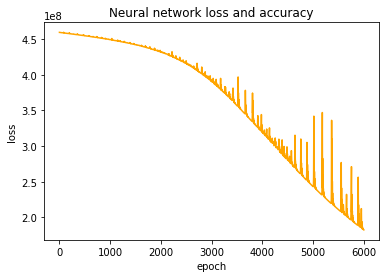

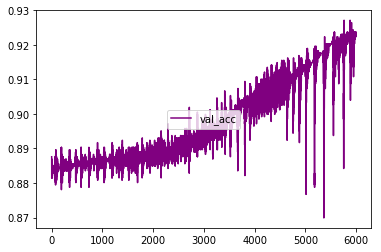

In [40]:
print(hitory.history.keys())


plt.plot(hitory.history['loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')



plt.show()
plt.plot(hitory.history['val_acc'], c = "purple")
plt.legend([ 'val_acc'], loc='center')


plt.show()

In [41]:
print(X2[1, 0, :], Y2[0, :, :])

NameError: name 'Y2' is not defined

In [42]:
# build model
output_size = 3
numSamples = 4892
numTimestepsPerSample = 100
numParametersPerTimestep = 8

Y2 = np.array(Y).reshape(Y.shape[0], Y.shape[1], 1)

model = Sequential()

model.add(Dense(300, input_shape=[100,8,]))
#model.add(CuDNNLSTM(3, input_shape = [100, 8], return_sequences=True))
model.add(Dense(output_size))
print(model.output_shape, "H")
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
print(model.summary())
model.fit(X2, Y2, batch_size=730, epochs = 10)

(None, 100, 3) H
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100, 300)          2700      
_________________________________________________________________
dense_10 (Dense)             (None, 100, 3)            903       
Total params: 3,603
Trainable params: 3,603
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Error when checking target: expected dense_10 to have shape (100, 3) but got array with shape (3, 1)

Epoch 1/100
4892/4892 [==============================] - 0s 5us/step - loss: 1219885477.2069 - acc: 0.6063
Epoch 2/100
4892/4892 [==============================] - 0s 5us/step - loss: 1219859620.7359 - acc: 0.6063
Epoch 3/100
4892/4892 [==============================] - 0s 5us/step - loss: 1219813558.9992 - acc: 0.6063
Epoch 4/100
4892/4892 [==============================] - 0s 5us/step - loss: 1219764070.6198 - acc: 0.6063
Epoch 5/100
4892/4892 [==============================] - 0s 6us/step - loss: 1219708392.3990 - acc: 0.6063
Epoch 6/100
4892/4892 [==============================] - 0s 6us/step - loss: 1219649876.8798 - acc: 0.6063
Epoch 7/100
4892/4892 [==============================] - 0s 5us/step - loss: 1219590608.9027 - acc: 0.6063
Epoch 8/100
4892/4892 [==============================] - 0s 5us/step - loss: 1219529543.0646 - acc: 0.6063
Epoch 9/100
4892/4892 [==============================] - 0s 5us/step - loss: 1219466772.3565 - acc: 0.6063
Epoch 10/100
4892/4892 [=============

In [349]:
X2[:,1,:].shape

(4892, 8)

In [330]:
model.fit(X2, Y, batch_size=73, epochs = 2)

ValueError: Error when checking input: expected dense_62_input to have 4 dimensions, but got array with shape (4892, 100, 8)

In [ ]:
# or 
model = Sequential()
model.add(Dense(10, input_shape=(1))
model.add(RepeatVector(10))
model.add(LSTM(1, return_sequences=True))

In [ ]:
# create dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3

trainX, trainY = create_dataset(dataset[0:int(dataset.shape[0]*0.75)], look_back)
testX, testY = create_dataset(dataset[(int(dataset.shape[0]*0.75)+1):], look_back)

print(trainY.shape)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [ ]:
# read in dataset that was pre-classified
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()

In [ ]:
# read in all data into a single dataframe
bigList = []
freqSpec = []
for ii in range(buzzClass.shape[0]):
    tmp = readMyFile(buzzClass.fileName[ii])
    
    # pad with 0's
    tmp = readMyFile(buzzClass.fileName[ii])
    pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02 - np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
    zx = np.repeat(0, len(pad))
    pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
    pdff.columns = tmp.columns

    tmp = pd.concat([tmp, pdff]).reset_index(drop = True)
    
    # calculate rolling variance
    tmp["varia"] = pd.Series((tmp.iloc[:,1] - np.mean(tmp.iloc[:,1]))).rolling(int(2000), center = True, min_periods = 1).var().tolist()
    
    # calculate frequency spectrum
    f, t, Sxx = signal.spectrogram(tmp.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
    Sxx = Sxx[0:50, :]
    #scale
    Sxx = Sxx - np.min(Sxx)
    Sxx = Sxx / np.max(Sxx)
    
    
    
    freqSpec.append(pd.DataFrame(np.transpose(Sxx)))
    
    # add classes to data
    tmp["buzz"] = 0
    tmp.loc[buzzClass.buzz1[ii]:buzzClass.buzz2[ii], "buzz"] = 1
    if(np.mod(ii, 10)) == 0:
        print(ii)
    
    tmp["filename"] = buzzClass.fileName[ii]
    bigList.append(tmp)

In [ ]:
df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)

In [ ]:
df.head()

In [ ]:
plt.plot(df.iloc[0:20000, 1])

In [ ]:
df.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mm = MinMaxScaler((0,1))
mm.fit(df.iloc[:, 1].values.reshape(-1, 1))
df["scaledBuzz"] = mm.transform(df.iloc[:, 1].values.reshape(-1, 1))


subSamp = np.arange(0, 20000, step = 50)# np.arange(0, df.shape[0], step = 5)
plt.figure(figsize=(20,5))
plt.plot(np.array(df.index[subSamp]), np.array(df.iloc[subSamp,5]))
#plt.scatter(df.index[subSamp], df.iloc[subSamp,2]*10, s = 0.5, c = df.iloc[subSamp,3])
plt.show()
df.shape

In [ ]:
# downsample dataset
print(df.shape)
subSamp = np.arange(0, df.shape[0], step = 10)# np.arange(0, df.shape[0], step = 5)
df = df.iloc[subSamp, :]
print(df.shape)

In [ ]:
seq = df.loc[:,"scaledBuzz"]

# timesteps = np.linspace(0, 2, num = 2000000)
# freq = ((np.sin(timesteps*timesteps/2*10*2*np.pi) + 1)**3 > 4 ) + 0.3
# seq = np.sin((freq*100 * timesteps) * 2 * np.pi)
# plt.plot(timesteps, seq)
# plt.plot(timesteps, freq + 1)

In [ ]:
from scipy import signal

f, t, Sxx = signal.spectrogram(np.array(seq), 200000, noverlap = 4000, nperseg = 5000)
Sxx = Sxx[0:10]
f = f[0:10]
plt.pcolormesh(t, f, Sxx)
plt.ylim(0,500)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
# buzzes = freq > 1.0
buzzes = df.buzz
plt.plot(buzzes[0:1000000])

In [ ]:
# scale dataset
from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(seq).reshape(-1,1))
plt.plot(dataset[0:10000])

In [ ]:
# create dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 100

trainX, trainY = create_dataset(dataset[0:int(dataset.shape[0]*0.75)], look_back)
testX, testY = create_dataset(dataset[(int(dataset.shape[0]*0.75)+1):], look_back)

print(trainY.shape)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



In [ ]:
trainX.shape
plt.figure(figsize=[10,5])
plt.plot(trainX[0:5000, 0, -1])

trainY= np.array(buzzes[look_back:(trainX.shape[0]+look_back)])
plt.plot(trainY[0:5000])

# refref: alignment might be off

In [ ]:
np.array(testY)

In [ ]:
testY=np.array(buzzes[(trainX.shape[0]+look_back):(trainX.shape[0] + look_back + testY.shape[0])])
plt.figure(figsize=[20,5])
plt.plot(testX[0:500000,0,0])
plt.plot(testY[0:500000])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping


earlystop = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='auto', min_delta = 0.0001)

# create and fit the LSTM network
model = Sequential()
model.add(CuDNNLSTM(400, input_shape=(1, look_back), return_sequences = True))
model.add(CuDNNLSTM(4, return_sequences = False))
# refref add more layers, and increase lookback
#model.add(Dense(4, input_shape=(1, trainX.shape[2] )))
model.add((Dense(1, activation = "sigmoid")))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hitory = model.fit(trainX, trainY, epochs=1000, batch_size=150000, verbose=1, callbacks = [earlystop])

In [ ]:
print(hitory.history.keys())


plt.plot(hitory.history['loss'], c = "orange")
plt.title('Neural network loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')
plt.xlabel('epoch')
plt.show()

In [ ]:
trainY = trainY.reshape(-1)
testY = testY.reshape(-1)

# make predictions
trainPredict = model.predict_classes(trainX)
testPredict = model.predict_classes(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# plot
plt.figure(figsize = [10, 5])
plt.plot(trainPredict, c="orange")
plt.plot(trainY[0,:])

plt.show()

plt.plot(testY[0,:])
plt.plot(testPredict[1:], c= 'orange')

In [ ]:
plt.figure(figsize = [10, 5])
plt.plot(testX[0:200000,0, 0])
plt.plot(testPredict[0:200000] + 1.1, c= 'pink')
plt.plot(testY[0,0:200000] + 1)